In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import copy
from random import randint
from scipy.optimize import differential_evolution

## Cargar el modelo victima

In [48]:
# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar estructura del modelo y adaptarla a 10 clases
resnet50 = models.resnet50(pretrained=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

# Cargar pesos
resnet50.load_state_dict(torch.load("CIFAR10_resnet50.pth", map_location=device))
resnet50 = resnet50.to(device)
resnet50.eval()

c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\artur\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\artur\AppData\Local\Temp\ipykernel_7944\1521559691.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future rel

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Cargar el dataset CIFAR10

In [49]:
transform = transforms.Compose([
    transforms.Resize(224),  # Importante para ResNet-50
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar dataset de prueba
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)

# Clases de CIFAR-10
classes = ('airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Obtener un batch de 25 imágenes
dataiter = iter(loader)
images, labels = next(dataiter)

Files already downloaded and verified


## Visualizar el dataset CIFAR10



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


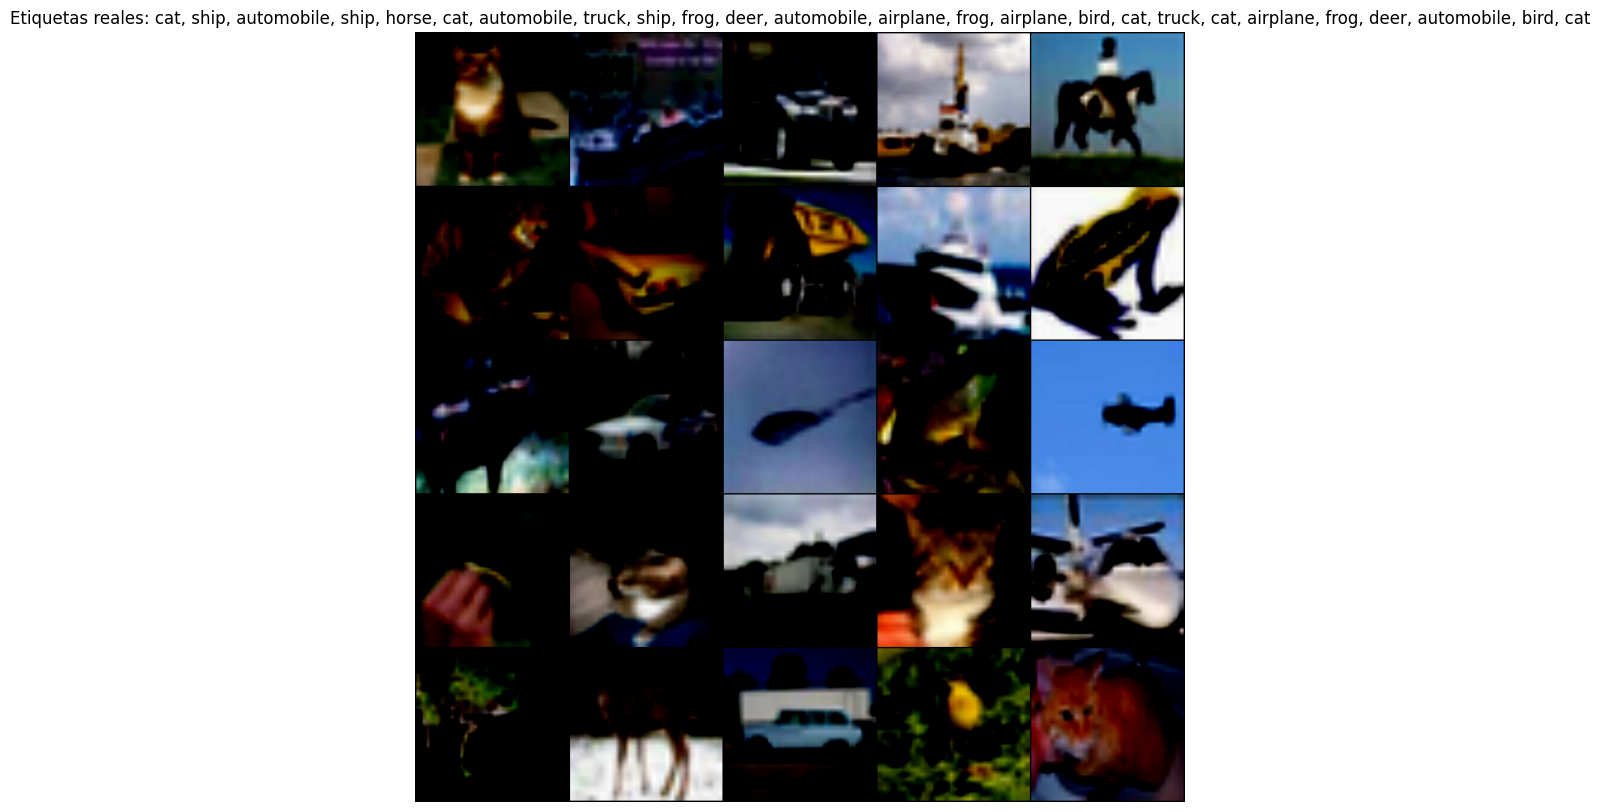

In [50]:
# Función para desnormalizar y mostrar una cuadrícula
def imshow(imgs, labels):
    imgs = torchvision.utils.make_grid(imgs, nrow=5, padding=2)
    npimg = imgs.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.title("Etiquetas reales: " + ", ".join(classes[labels[i]] for i in range(25)))
    plt.show()

# Mostrar las imágenes
imshow(images, labels)

## One Pixel Attack


In [51]:
def evolutionary_one_pixel_attack(model, image, label, num_pixels=1, epsilon=0.2, max_iter=30, pop_size=15):
    c, h, w = image.shape[1:]
    bounds = []

    for _ in range(num_pixels):
        for _ in range(c):
            bounds.extend([(0, h - 1), (0, w - 1), (0, 1)])

    def perturb(x):
        adv_image = image.clone().detach()
        for i in range(num_pixels):
            for ch in range(c):
                idx = (i * c + ch) * 3
                y = int(x[idx])
                x_ = int(x[idx + 1])
                val = float(x[idx + 2]) * epsilon
                adv_image[0, ch, y, x_] = torch.clamp(adv_image[0, ch, y, x_] + val, 0, 1)
        return adv_image

    def fitness(x):
        adv_img = perturb(x)
        with torch.no_grad():
            output = model(adv_img.to(image.device))
            probs = F.softmax(output, dim=1)
            return probs[0, label.item()].item()  # Cuanto menor, mejor


    result = differential_evolution(
        fitness,
        bounds,
        maxiter=max_iter,
        popsize=pop_size,
        recombination=0.7,
        tol=1e-3,
        mutation=(0.8, 1.2),
        disp=False,
        polish=False,
        updating="deferred"
    )

    final_img = perturb(result.x).to(image.device)
    final_pred = model(final_img).argmax(dim=1).item()
    if final_pred != label.item():
        print(f"✅ Ataque exitoso: {label.item()} → {final_pred}")
    else:
        print("Ataque fallido.")
    return final_img


Files already downloaded and verified
Confianza en clase real (automobile): 100.00%
🔁 Buscando otra imagen...
Confianza en clase real (cat): 100.00%
🔁 Buscando otra imagen...
Confianza en clase real (deer): 52.51%
Ataque exitoso: deer → horse


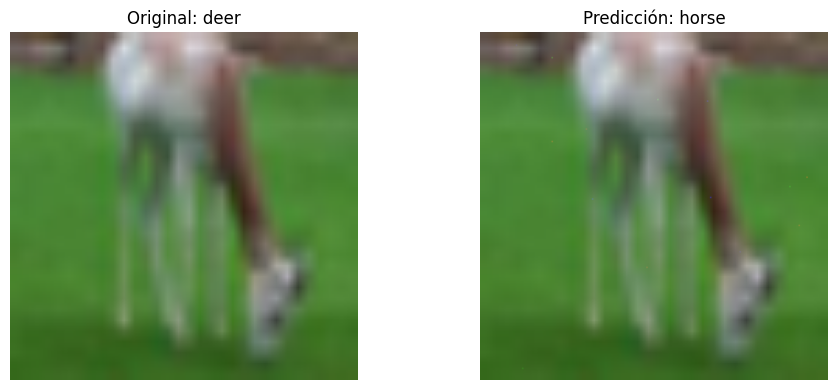

In [52]:
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=1, shuffle=True)

# Obtener imagen con confianza < 95%
while True:
    image, label = next(iter(testloader))
    image, label = image.to(device), label.to(device)

    output = resnet50(image)
    probs = F.softmax(output, dim=1)
    confianza_real = probs[0, label.item()].item()
    
    print(f"Confianza en clase real ({classes[label.item()]}): {confianza_real:.2%}")
    if confianza_real < 0.95:
        break
    else:
        print("🔁 Buscando otra imagen...")

# Ataque evolutivo perfeccionado
def evolutionary_one_pixel_attack(model, image, label, num_pixels=5, epsilon=0.25, max_iter=50, pop_size=30):
    c, h, w = image.shape[1:]
    bounds = []

    for _ in range(num_pixels):
        for _ in range(c):
            bounds.extend([(0, h - 1), (0, w - 1), (0, 1)])

    def perturb(x):
        adv_image = image.clone().detach()
        for i in range(num_pixels):
            for ch in range(c):
                idx = (i * c + ch) * 3
                y = int(x[idx])
                x_ = int(x[idx + 1])
                val = float(x[idx + 2]) * epsilon
                adv_image[0, ch, y, x_] = torch.clamp(adv_image[0, ch, y, x_] + val, 0, 1)
        return adv_image

    def fitness(x):
        adv_img = perturb(x)
        with torch.no_grad():
            output = model(adv_img.to(image.device))
            probs = F.softmax(output, dim=1)
            return probs[0, label.item()].item()  # Menor confianza = mejor

    result = differential_evolution(
        fitness,
        bounds,
        maxiter=max_iter,
        popsize=pop_size,
        recombination=0.9,
        tol=1e-3,
        mutation=(0.9, 1.5),
        disp=False,
        polish=True,              # Refinamiento final
        updating="deferred"
    )

    final_img = perturb(result.x).to(image.device)
    final_pred = model(final_img).argmax(dim=1).item()
    if final_pred != label.item():
        print(f"Ataque exitoso: {classes[label.item()]} → {classes[final_pred]}")
    else:
        print("Ataque fallido.")
    return final_img

# Aplicar ataque
resnet50.eval()
adv_image = evolutionary_one_pixel_attack(
    resnet50,
    image,
    label,
    num_pixels=5,
    epsilon=0.25,
    max_iter=20,
    pop_size=10
)

# Visualización
def imshow(tensor, title):
    img = tensor.squeeze().detach().cpu().numpy()
    img = (img * 0.5) + 0.5  # Desnormalizar
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

real_label_str = classes[label.item()]
pred_adv = resnet50(adv_image).argmax(dim=1).item()
pred_adv_str = classes[pred_adv]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
imshow(image, f"Original: {real_label_str}")
plt.subplot(1, 2, 2)
imshow(adv_image, f"Predicción: {pred_adv_str}")
plt.tight_layout()
plt.show()


## Defensas frente a OnePixel Attack

Original: horse
Adversarial: horse
Median Blur: deer


You should consider upgrading via the 'C:\Users\artur\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


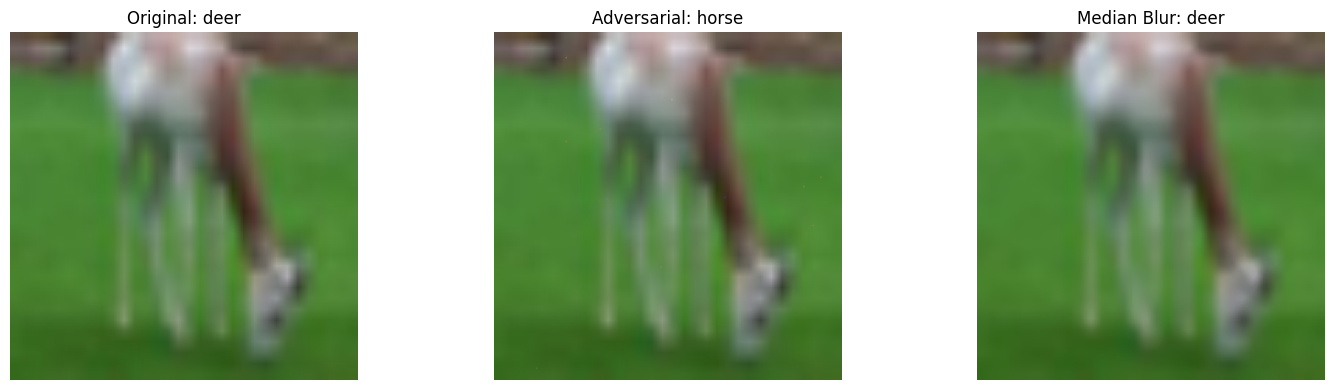

In [53]:
!pip install opencv-python
import cv2

# Función de median blur 
def apply_median_blur(image, kernel_size=5):
    image = (image + 1) / 2  # de [-1, 1] a [0, 1]

    img_np = image.squeeze().detach().cpu().numpy()
    blurred_np = np.zeros_like(img_np)

    for c in range(img_np.shape[0]):
        img_8bit = ((img_np[c] * 255).clip(0, 255)).astype(np.uint8)
        blurred_np[c] = cv2.medianBlur(img_8bit, kernel_size) / 255.0

    blurred_tensor = torch.tensor(blurred_np).unsqueeze(0).float().to(image.device)
    return (blurred_tensor * 2) - 1  # vuelve a [-1, 1]

# Aplicar filtro a imagen adversarial
blurred_adv = apply_median_blur(adv_image.clone())

# Clasificación después del filtro
pred_blurred = resnet50(blurred_adv).argmax(dim=1).item()
pred_blurred_str = classes[pred_blurred]

print(f"Original: {pred_adv_str}")
print(f"Adversarial: {pred_adv_str}")
print(f"Median Blur: {pred_blurred_str}")

# Visualización 
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
imshow(image, f"Original: {classes[label.item()]}")
plt.subplot(1, 3, 2)
imshow(adv_image, f"Adversarial: {classes[pred_adv]}")
plt.subplot(1, 3, 3)
imshow(blurred_adv, f"Median Blur: {pred_blurred_str}")
plt.tight_layout()
plt.show()

Feature Squeezing aplicado con 4 bits
Original:     deer
Adversarial:  horse
Squeezed:     horse
El ataque se mantiene tras squeezing


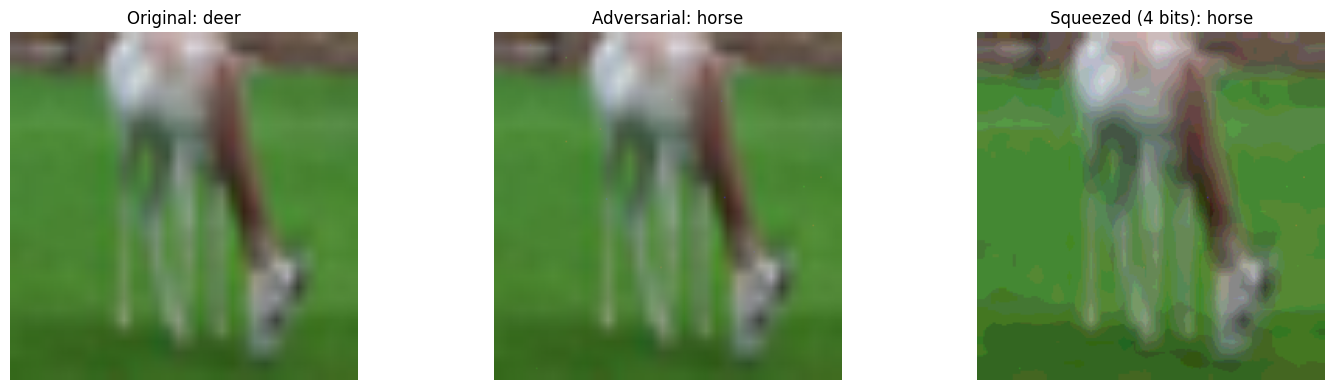

In [54]:
# Función de Feature Squeezing 
def feature_squeeze(image, bits=4):
    image = (image + 1) / 2
    levels = 2 ** bits
    squeezed = torch.round(image * (levels - 1)) / (levels - 1)
    return (squeezed * 2) - 1

# Aplicar squeezing a imagen adversarial
squeezed_image = feature_squeeze(adv_image.clone())

# Predicciones 
true_label = label.item()
pred_squeezed = resnet50(squeezed_image).argmax(dim=1).item()

# Mostrar predicciones
print("Feature Squeezing aplicado con", 4, "bits")
print(f"Original:     {classes[true_label]}")
print(f"Adversarial:  {classes[pred_adv]}")
print(f"Squeezed:     {classes[pred_squeezed]}")

if pred_squeezed == true_label:
    print("El ataque ha sido revertido con Feature Squeezing")
elif pred_squeezed == pred_adv:
    print("El ataque se mantiene tras squeezing")
else:
    print("El squeezing ha cambiado la clase, pero no ha restaurado la original")

# Visualización comparativa
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
imshow(image, f"Original: {classes[true_label]}")
plt.subplot(1, 3, 2)
imshow(adv_image, f"Adversarial: {classes[pred_adv]}")
plt.subplot(1, 3, 3)
imshow(squeezed_image, f"Squeezed ({4} bits): {classes[pred_squeezed]}")
plt.tight_layout()
plt.show()
